In [1]:
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import scipy
import random
import cmath
#import pylops # might not need
import math
import pyproximal

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist, mnist
from tensorflow.keras.models import Model
from tensorflow.keras.saving import register_keras_serializable, deserialize_keras_object
from tensorflow.test import compute_gradient
from tensorflow.compat.v1 import assign_sub

from scipy.sparse.linalg import LinearOperator
from scipy.fft import fft, ifft, fft2, ifft2
from scipy.optimize import minimize

import autosetup 
from backpropagation import CBP, CBP_decoder
from complex_optimizer import Complex_SGD, adaptive_stepsize

In [3]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


Some nice tensorflow links
https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing#putting_it_all_together_an_end-to-end_example 
https://www.tensorflow.org/guide/keras/functional_api
https://www.tensorflow.org/api_docs/python/tf/keras/Layer#used-in-the-notebooks
https://www.tensorflow.org/api_docs/python/tf/keras/Layer#call

## Autoencoder ptygenography

### Loading datasets

In [ ]:
# first draft code from: https://www.tensorflow.org/tutorials/generative/autoencoder

In [2]:
## prep different datasets

# original dataset
(x_train, cls_train), (x_test, cls_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255. #normalize the data
x_test = x_test.astype('float32') / 255.

print("Size training dataset: ", x_train.shape)
print("Size testing dataset: ", x_test.shape)

# dataset of 10 x 10 pixels instead of 28 x 28
x_train_temp = x_train[..., tf.newaxis]
x_train_temp = tf.image.resize(x_train_temp, [10,10])
x_train_small = x_train_temp[:,:,:,0]

x_test_temp = x_test[..., tf.newaxis]
x_test_temp = tf.image.resize(x_test_temp, [10,10])
x_test_small = x_test_temp[:,:,:,0]

print("Size lower resolution training set: ", x_train_small.shape)
print("Size lower resolution testing set: ", x_test_small.shape)

# dataset of 10 x 10 pixels as complex images
x_train_cx_small = tf.complex(np.ones((x_train_small.shape)).astype('float32'), x_train_small)
x_test_cx_small = tf.complex(np.ones((x_test_small.shape)).astype('float32'), x_test_small)

print("Size of the complex and lower res training set: ",x_train_cx_small.shape)

# filter dataset for 3's to 10 x 10 complex set
#training
x_train_3 = x_train[np.where(cls_train==3),:] 
x_train_3 = x_train_3.astype('float32')
x_train_3 = tf.squeeze(x_train_3)

x_train_temp = x_train_3[..., tf.newaxis]
x_train_temp = tf.image.resize(x_train_temp, [10,10])
x_train_3_small = x_train_temp[:,:,:,0]

x_train_3_cx_small = tf.complex(np.ones((x_train_3_small.shape)).astype('float32'), x_train_3_small)

print("Size complex lower resolution training set of only 3's: ", x_train_3_cx_small.shape)

#testing
x_test_3 = x_test[np.where(cls_test==3),:] 
x_test_3 = x_test_3.astype('float32')
x_test_3 = tf.squeeze(x_test_3)

x_test_temp = x_test_3[..., tf.newaxis]
x_test_temp = tf.image.resize(x_test_temp, [10,10])
x_test_3_small = x_test_temp[:,:,:,0]

x_test_3_cx_small = tf.complex(np.ones((x_test_3_small.shape)).astype('float32'), x_test_3_small)

print("Size complex lower resolution testing set of only 3's: ", x_test_3_cx_small.shape)

Size training dataset:  (60000, 28, 28)
Size testing dataset:  (10000, 28, 28)
Size lower resolution training set:  (60000, 10, 10)
Size lower resolution testing set:  (10000, 10, 10)
Size of the complex and lower res training set:  (60000, 10, 10)
Size complex lower resolution training set of only 3's:  (6131, 10, 10)
Size complex lower resolution testing set of only 3's:  (1010, 10, 10)


In [145]:
## export
export_train = x_train_3_cx_small.numpy()
export_test = x_test_3_cx_small.numpy()

np.save('MNIST_100_only3_train.npy', export_train)
np.save('MNIST_100_only3_test.npy', export_test)

In [3]:
## set current dataset
dataset = x_train_3_cx_small
datatest = x_test_3_cx_small
dataset_size = dataset[0]
nx = dataset.shape[1]
n = int(nx**2)

print("Shape current dataset using: ", dataset.shape)
print("Length of side: ", nx)

Shape current dataset using:  (6131, 10, 10)
Length of side:  10


In [ ]:
# load MNIST dataset from ptygenography instead
X_pty = np.load('MNIST_64_only3.npy')
n = X_pty.shape[1]
nx = int(np.sqrt(n))
print(X_pty.shape)

X_tf = tf.convert_to_tensor(X_pty, dtype=tf.complex64)
print(type(X_tf))
print(X_tf.shape)

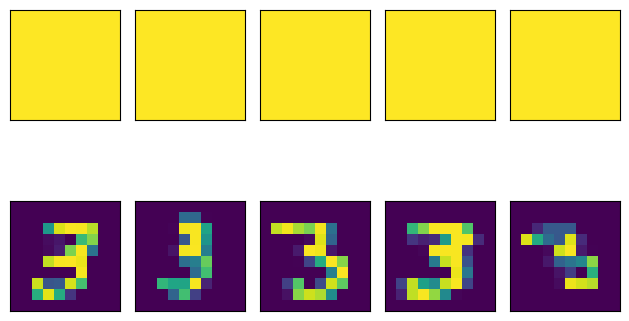

In [147]:
# show the data
ns = 5
fig, ax = plt.subplots(2,ns)

for i in range(ns):
    x = dataset[i]
    ax[0,i].imshow(np.real(x).reshape((nx,nx)),clim=[0,1])
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].imshow(np.imag(x).reshape((nx,nx)),clim=[0,1])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
fig.tight_layout()

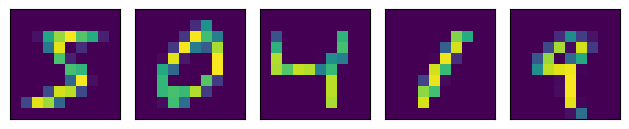

In [3]:
# representation training dataset (real case)
ns = 5
fig, ax = plt.subplots(1,ns)

for i in range(ns):
    x = x_train_small[i]
    ax[i].imshow(np.real(x).reshape((10,10)),clim=[0,1])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
fig.tight_layout()

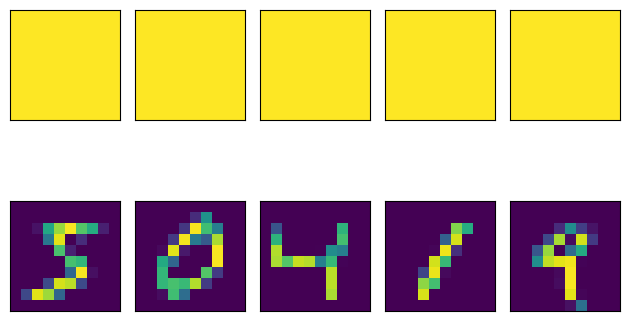

In [4]:
ns = 5
fig, ax = plt.subplots(2,ns)

for i in range(ns):
    x = x_train_cx_small[i]
    ax[0,i].imshow(np.real(x).reshape((10,10)),clim=[0,1], cmap= 'viridis')
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].imshow(np.imag(x).reshape((10,10)),clim=[0,1], cmap='viridis')
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
fig.tight_layout()


### Training loop

In [22]:
## parameters relevant to training
EPOCHS = 50
dataset_size = dataset.shape[0]
reshape_dataset = tf.reshape(dataset, (dataset_size,-1))
sample_shape = reshape_dataset.shape[-1] # data dimension
n = sample_shape # used later
nx = int(np.sqrt(sample_shape)) # one side of the 2D image
latent_dim = 10 # reduction of data 

print("Number of epochs", EPOCHS)
print("Dataset size: ", dataset_size)
print("Dimension of one sample: ", sample_shape)
print("Latent dimension: ", latent_dim)
print("Entire dimensions dataset: ", reshape_dataset.shape)

Number of epochs 50
Dataset size:  6131
Dimension of one sample:  100
Latent dimension:  10
Entire dimensions dataset:  (6131, 100)


In [148]:
# wrapper for training
@tf.function
def train_step(x, alpha, encoder, decoder, optimizer):
    y = decoder(encoder(x))
    loss_value = autosetup.loss_MSE(y, x)
    grads_and_vars = CBP(x, y, encoder, decoder, autosetup.dLossdaL, autosetup.Jac_modrelu)
    new_alpha = adaptive_stepsize(x, y, alpha, encoder, decoder, autosetup.loss_MSE, grads_and_vars)
    _ = optimizer.apply_gradients(grads_and_vars, alpha = alpha)
    return loss_value, new_alpha

In [150]:
# ref: https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch

train_dataset = (
    tf.data.Dataset.from_tensor_slices(reshape_dataset)
    .shuffle(dataset_size, reshuffle_each_iteration=True) # reshuffle the entire dataset
    .batch(1)
)

encoder = autosetup.ComplexEncoder([50, latent_dim])
decoder = autosetup.ComplexDecoder([50, sample_shape])

# initialize layers: on first call their shape is set based on the shapes of the first data
dummy = tf.zeros((1, sample_shape), dtype=tf.complex64)
_ = decoder(encoder(dummy))

print(type(train_dataset))

optimizer = Complex_SGD()
alpha = 1e-4 # initial value

for epoch in range(EPOCHS):
    print(f"\nStart of epoch {epoch+1}")
    start_time = time.time()

    count = 0
    epoch_loss = 0.0
    for x in train_dataset:
        loss, alpha = train_step(x, alpha, encoder, decoder, optimizer)

        count += 1 # this is a bit ugly
        epoch_loss += loss.numpy()

        if count % (int(dataset_size/10)) == 0:
            print(
                "Training loss (for one sample) at sample %d: %.4f"
                % (count, float(loss))
            )

    avg_loss = epoch_loss/(dataset_size)
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.5f}") 
    print("Time taken: %.2fs" % (time.time() - start_time))

<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>

Start of epoch 1
Training loss (for one sample) at sample 613: 13.6847
Training loss (for one sample) at sample 1226: 12.1149
Training loss (for one sample) at sample 1839: 7.5868
Training loss (for one sample) at sample 2452: 4.9213
Training loss (for one sample) at sample 3065: 8.7666
Training loss (for one sample) at sample 3678: 4.1126
Training loss (for one sample) at sample 4291: 2.6608
Training loss (for one sample) at sample 4904: 3.0486
Training loss (for one sample) at sample 5517: 4.1503
Training loss (for one sample) at sample 6130: 3.2792
Epoch 1 | Loss: 9.69450
Time taken: 11.79s

Start of epoch 2
Training loss (for one sample) at sample 613: 5.0238
Training loss (for one sample) at sample 1226: 3.4438
Training loss (for one sample) at sample 1839: 5.8705
Training loss (for one sample) at sample 2452: 3.1020
Training loss (for one sample) at sample 3065: 2.3332
Training loss (for one sample) at sample 3678: 5.80

In [151]:
## save the encoder weights (not needed for least squares but helpful in generating examples)
wrap_encoder = autosetup.EncoderSave(encoder)
_ = wrap_encoder(tf.zeros((1, sample_shape), dtype = tf.complex64))

wrap_encoder.save_weights("encoder_50epochs_X3train_k10.weights.h5")

In [152]:
## save the decoder weights
wrap_decoder = autosetup.DecoderSave(decoder)
_ = wrap_decoder(tf.zeros((1, latent_dim), dtype = tf.complex64))

wrap_decoder.save_weights("decoder_50epochs_X3train_k10.weights.h5")

In [5]:
## load the encoder weights
encoder_from_load = autosetup.ComplexEncoder([50, latent_dim])
encoder_model_from_load = autosetup.EncoderSave(encoder_from_load)

## load the decoder weights
decoder_from_load = autosetup.ComplexDecoder([50, sample_shape])
model_from_load = autosetup.DecoderSave(decoder_from_load)

# build
dummy_enc = tf.zeros((1, sample_shape), dtype = tf.complex64)
_ = encoder_from_load(dummy_enc)
_ = encoder_model_from_load(dummy_enc)

dummy_dec = tf.zeros((1, latent_dim), dtype = tf.complex64)
_ = decoder_from_load(dummy_dec)
_ = model_from_load(tf.zeros((1, latent_dim), dtype = tf.complex64))

# load
#model_from_load.load_weights("saved_decoder_test.weights.h5")
model_from_load.load_weights("decoder_50epochs_X3train_k10.weights.h5")
encoder_model_from_load.load_weights("encoder_50epochs_X3train_k10.weights.h5")

In [ ]:
## test if it does the same
x_testing = tf.reshape(x_train_cx_small[0], [1,-1])
print(x_testing.shape)
print(type(x_testing))
y = encoder(x_testing)

# if zeros are returned, test succesfull
#print(decoder(y) - model_from_load.decoder(y))

(1, 100)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[[1.0560035 -7.74386898e-02j 1.0573239 +8.20555985e-02j
  1.1151439 -9.14341062e-02j 1.0566394 -3.52024026e-02j
  0.93093467-7.01772124e-02j 0.98010314-1.08131403e-02j
  1.0116947 -6.06522523e-02j 1.0721003 +2.21436489e-02j
  0.9977986 +7.54325837e-02j 1.1252183 -9.12407115e-02j
  0.98584217+7.65499771e-02j 1.1194189 -3.10081970e-02j
  1.0479074 +8.06405470e-02j 1.0364313 -1.06292199e-02j
  0.9330173 +1.00438990e-01j 1.053675  +2.20988348e-01j
  1.0738726 +2.39383459e-01j 1.0857968 +4.43139449e-02j
  1.03635   -7.87219480e-02j 0.9503862 -4.71685864e-02j
  0.9079056 -1.49019165e-02j 0.8564091 -3.92761752e-02j
  0.9362015 +5.44368252e-02j 0.9575463 +1.76161274e-01j
  1.0529252 +5.25073826e-01j 1.0500501 +6.51388526e-01j
  1.0366496 +5.24619102e-01j 1.1171299 +3.76128852e-01j
  0.96216846+6.17846064e-02j 1.0660409 +8.73341635e-02j
  1.0847453 -5.12152584e-03j 1.0241363 +4.79821227e-02j
  0.9760021 +1.58020541e-01j 1

In [6]:
## run if decoder should be loaded from save
encoder = encoder_model_from_load.encoder
decoder = model_from_load.decoder

#### Extracting and wrapping autoencoder function

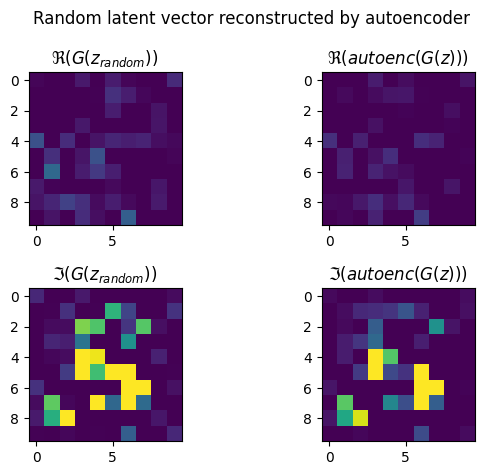

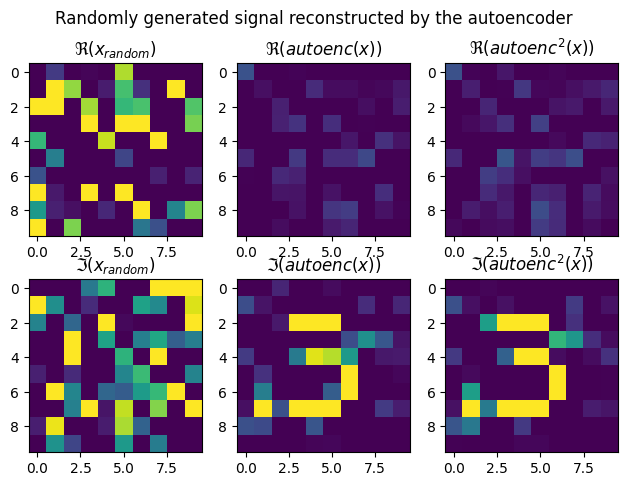

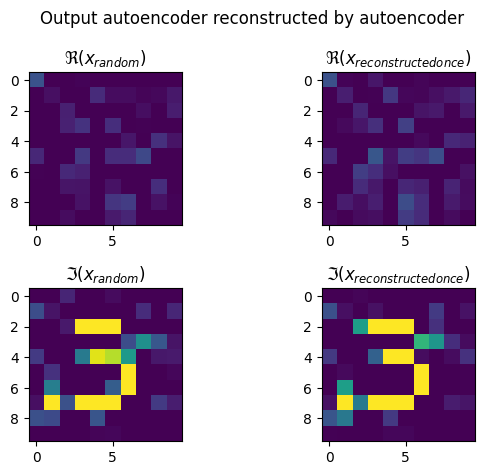

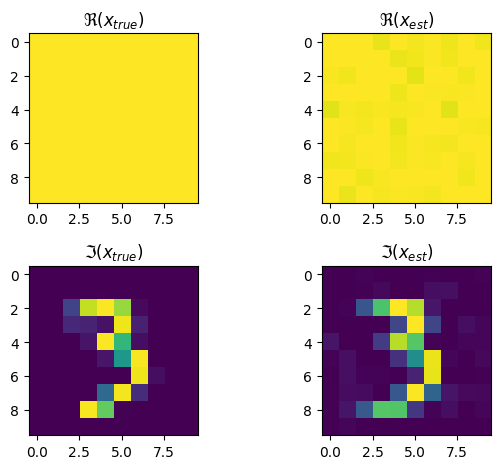

In [43]:
## testing the quality of the encoder decoder
# TODO maybe make decoder the function that can handle both np and tf input? by converting np input
# random input latent space
z_random = np.random.normal(size=(1,latent_dim)) + 1j*np.random.normal(size=(1,latent_dim))
test_z = decoder(make_tensor(z_random))

z_plot = test_z.numpy().flatten()
z_again_tf = decoder(encoder(test_z))
z_again = z_again_tf.numpy().flatten()

# plot results
fig, ax = plt.subplots(2,2)

ax[0,0].imshow(np.real(z_plot.reshape((nx,nx))),clim=[0,1])
ax[0,0].set_title(r'$\Re(G(z_{random}))$')
ax[1,0].imshow(np.imag(z_plot.reshape((nx,nx))),clim=[0,1])
ax[1,0].set_title(r'$\Im(G(z_{random}))$')
ax[0,1].imshow(np.real(z_again.reshape((nx,nx))),clim=[0,1])
ax[0,1].set_title(r'$\Re(autoenc(G(z)))$')
ax[1,1].imshow(np.imag(z_again.reshape((nx,nx))),clim=[0,1])
ax[1,1].set_title(r'$\Im(autoenc(G(z)))$')

fig.suptitle("Random latent vector reconstructed by autoencoder")
fig.tight_layout()

# random input original space
x_random = np.random.normal(size=(1,sample_shape)) + 1j*np.random.normal(size=(1,sample_shape))
x_tensor = make_tensor(x_random)
x_random_recon_tf = decoder(encoder(x_tensor)) 
x_random_recon = x_random_recon_tf.numpy().flatten()

x_random = x_random.flatten()

# reconstructed output now through the autoencoder
x_again_tf = decoder(encoder(x_random_recon_tf))
x_again = x_again_tf.numpy().flatten()

# plot results
fig, ax = plt.subplots(2,3)

ax[0,0].imshow(np.real(x_random.reshape((nx,nx))),clim=[0,1])
ax[0,0].set_title(r'$\Re(x_{random})$')
ax[1,0].imshow(np.imag(x_random.reshape((nx,nx))),clim=[0,1])
ax[1,0].set_title(r'$\Im(x_{random})$')
ax[0,1].imshow(np.real(x_random_recon.reshape((nx,nx))),clim=[0,1])
ax[0,1].set_title(r'$\Re(autoenc(x))$')
ax[1,1].imshow(np.imag(x_random_recon.reshape((nx,nx))),clim=[0,1])
ax[1,1].set_title(r'$\Im(autoenc(x))$')
ax[0,2].imshow(np.real(x_again.reshape((nx,nx))),clim=[0,1])
ax[0,2].set_title(r'$\Re(autoenc^2(x))$')
ax[1,2].imshow(np.imag(x_again.reshape((nx,nx))),clim=[0,1])
ax[1,2].set_title(r'$\Im(autoenc^2(x))$')

fig.suptitle("Randomly generated signal reconstructed by the autoencoder")
fig.tight_layout()


# plot results
fig, ax = plt.subplots(2,2)


ax[0,0].imshow(np.real(x_random_recon.reshape((nx,nx))),clim=[0,1])
ax[0,0].set_title(r'$\Re(x_{random})$')
ax[1,0].imshow(np.imag(x_random_recon.reshape((nx,nx))),clim=[0,1])
ax[1,0].set_title(r'$\Im(x_{random})$')
ax[0,1].imshow(np.real(x_again.reshape((nx,nx))),clim=[0,1])
ax[0,1].set_title(r'$\Re(x_{reconstructed once})$')
ax[1,1].imshow(np.imag(x_again.reshape((nx,nx))),clim=[0,1])
ax[1,1].set_title(r'$\Im(x_{reconstructed once})$')

fig.suptitle("Output autoencoder reconstructed by autoencoder")
fig.tight_layout()

# comparing training image with result of decoder
x_testing = tf.reshape(datatest[1], [1,-1])
y = encoder(x_testing)
x_recon = decoder(y)
im_x = tf.math.imag(tf.reshape(x_recon, (1,nx,nx)))

x_plottable = datatest[1].numpy().flatten()
x_plot_recon = x_recon.numpy().flatten()

plot_result(x_plottable, x_plot_recon)

In [25]:
# compute function generative map
def make_tensor_shape(z):
    #z = z.reshape((1,-1))
    tensor_z = tf.convert_to_tensor(z, dtype=tf.complex64)
    return tf.reshape(tensor_z,[1,-1])

def make_tensor(z):
    return tf.convert_to_tensor(z, dtype=tf.complex64)

# wrapper for decoder to numpy function
def decoderfunc_1D(z, decoder):
    '''
    Converts the autoencoder.decoder function into a generative embedding function

    input:
        z:              np.array of length (latent_dim)
        decoder:        custom class autosetup.ComplexDecoder, numpy.array(sample size, latent_dim) --> tensor(sample size, dim^2))    

    output:
        decoderfunc_1D: function that maps z to numpy array of lenght dim^2 (flattened original image). flatten() ensures shape (n,) and not (1,n)
    '''
    return decoder(tf.reshape(make_tensor(z), [1,-1])).numpy().flatten()

# wrapper for Jacobian computation to numpy function
def jac_decoder_1D(z, decoder, type = "normal"):
    '''
    Converts the CBP_decoder computation into a numpy function, outputting the R or R*-derivative of the decoder in z as a numpy array
    NOTE: activation function is hardcoded at this point

    input:
        z:              np.array of length (latent_dim)
        decoder:        custom class autosetup.ComplexDecoder, numpy.array(sample size, latent_dim) --> tensor(sample size, dim^2))
        type:           str, either "normal" or "conj", indicating the R or the R*-derivative
    '''
    dG_dz, dG_dzstar = CBP_decoder(tf.reshape(make_tensor(z), [1,-1]), decoder, autosetup.Jac_modrelu)
    if type == "normal":
        return dG_dz.numpy()
    elif type == "conj":
        return dG_dzstar.numpy()
    else:
        raise ValueError(f"Invalid type '{type}. Must be 'normal' or 'conj'.")        

### Integrate with least squares signal optimization

In [ ]:
class Op:
    def __init__(self, fun, jac, shape):
        self.eval = fun
        self.jac = jac
        self.shape = shape
        
def objective(z, y, A, G, Gstar, w=1, lmbda = 0):
    """
    LS objective
        (0.5)*\|A(G(z)) - y\|_2^2 + 0.5*lmbda**2*\|w*z\|_2^2
    """
    if len(y) != A.shape[0]:
        print("y and A don't match")
        return
    if len(z)//2 != G.shape[1]:
        print("z and G don't match")
        return
    if A.shape[1] != G.shape[0]:
        print("A and G don't match!")
        return
    
    k  = len(z)//2
    zc = z[:k] + 1j*z[k:]
    
    xc = G.eval(zc)
    Dx = G.jac(zc)
    Dxstar = Gstar.jac(zc)

    #print("Dx norm", np.linalg.norm(Dx @ np.ones_like(zc)))
    
    yp = A.eval(xc)
    Dy = A.jac(xc)

    #print("Dy", Dy.shape)

    DF = Dxstar.T@Dy.T + Dx.H@Dy.H

    val    = (0.5)*np.linalg.norm(yp - y)**2 + (0.5*lmbda**2)*np.linalg.norm(w*zc)**2
    #gradc  = Dx.H@(Dy.H@(yp - y)) + (lmbda**2)*(w*w)*zc
    gradc  = DF@(yp - y) + (lmbda**2)*(w*w)*zc

    print("val", val)
    print("first element gradc", gradc[0])
    
    grad  = np.concatenate((np.real(gradc), np.imag(gradc)))
    
    return val, grad

def reconstruct(xtrue, A, G, Gstar, w=1, sigma=0, lmbda=0):
    # sizes
    m,n = A.shape
    n,k = G.shape
    
    # generate data
    yobs  = A.eval(xtrue) + sigma*np.random.randn(m)

    # inference
    guess_z0 = np.concatenate([np.ones(k), np.ones(k)]) # can add 0.5 to initial value
    fake_z0_tf = encoder(make_tensor_shape(xtrue))
    fake_z0_cx = fake_z0_tf.numpy().flatten()
    fake_z0 = np.concatenate([np.real(fake_z0_cx), np.imag(fake_z0_cx)])

    result = minimize(objective, x0=guess_z0, args=(yobs, A, G, Gstar, w, lmbda), method='L-BFGS-B', jac=True, options={
        'maxiter': 20000,      # total outer iterations
        'maxls': 50,          # line search steps per iteration
        'ftol' : 1e-16,
        'gtol': 1e-16,         # gradient tolerance
        'disp': True          # print optimization log
    })
    
    # result = minimize(objective, np.concatenate([np.ones(k), 0.5*np.ones(k)]), args=(yobs, A, G, w, lmbda), method='Powell', jac=True, options={
    #     'maxiter': 1000,      # total outer iterations
    #     'ftol' : 1e-10,
    #     'disp': True          # print optimization log
    # })

    # result
    zhat = result.x[:k] + 1j*result.x[k:]
    xhat = G.eval(zhat)

    print("zhat", zhat)
    print("xhat", xhat)

    print("Result message:", result.message)
    print("Result status:", result.status)
    print("Function evals:", result.nfev)
    print("Jacobian evals:", result.njev)
    print("Final gradient norm:", np.linalg.norm(result.jac))
    
    # correct global phase
    #phi = np.mean(np.angle(xtrue/(xhat + 1e-16*np.ones_like(xhat)))) # avoid division by zero for bad reconstructions
    phi = np.mean(np.angle(xtrue/xhat)) 
    xhat_corr = np.exp(1j*phi)*xhat
    
    # relative error
    error = np.linalg.norm(xhat_corr - xtrue)/np.linalg.norm(xtrue)
    
    # return
    return error, xhat_corr, yobs, result

def plot_result(xtrue, xhat):
    n  = len(xtrue)
    nx = int(np.sqrt(n))
    
    # plot results
    fig, ax = plt.subplots(2,2)

    ax[0,0].imshow(np.real(xtrue.reshape((nx,nx))),clim=[0,1])
    ax[0,0].set_title(r'$\Re(x_{true})$')
    ax[1,0].imshow(np.imag(xtrue.reshape((nx,nx))),clim=[0,1])
    ax[1,0].set_title(r'$\Im(x_{true})$')
    ax[0,1].imshow(np.real(xhat.reshape((nx,nx))),clim=[0,1])
    ax[0,1].set_title(r'$\Re(x_{est})$')
    ax[1,1].imshow(np.imag(xhat.reshape((nx,nx))),clim=[0,1])
    ax[1,1].set_title(r'$\Im(x_{est})$')

    fig.tight_layout()

In [45]:
def MaskedFourier(M):
    """
    Defined masked 2D fourier transform as linear operator.
    
    input:
        M - 3D array of size n x n x m containing m masks of size n x n
        
    out:
        A - linear operator representing the masked Fourier transforms
        
    
    """
    nx = M.shape[0]
    mx = M.shape[2]
    
    mv  = lambda x : fft2(M*(x.reshape((nx,nx,1))), axes=(0,1)).flatten()
    rmv = lambda y : nx*nx*np.sum(np.conj(M)*ifft2(y.reshape((nx,nx,mx)), axes=(0,1)),axis=2).flatten()
    A   = LinearOperator((mx*nx*nx, nx*nx), matvec=mv, rmatvec=rmv) # rmatvec is conjugate operation, so A^H * v
    
    return A

In [125]:
# define forward operator with binary masks
mx = 100       # number of masks
m  = mx * n

M = np.random.randn(nx,nx,mx)
M[M<0]=0
M[M>0]=1

MF   = MaskedFourier(M)
print(MF.shape)
Afun = lambda x : np.abs(MF@x)**2
Ajac = lambda x : LinearOperator((m, n), matvec=lambda z : (MF@x)*np.conj(MF@np.conj(z)), rmatvec=lambda z : (MF.H@((MF@x)*z)))

A    = Op(fun = Afun, jac = Ajac, shape=(m,n))

(10000, 100)


In [124]:
# get prior from decoder
k               = latent_dim
block_identity  = lambda mat : np.concatenate((mat, np.eye(n)), axis=1)
block_zeros     = lambda mat : np.concatenate((mat, np.zeros((n,n))), axis=1)


#define generative models
I = Op(fun = lambda z : z, jac = lambda z: LinearOperator((n, n), matvec = lambda z : z, rmatvec = lambda z : z), shape=(n,n))

Istar = Op(fun = lambda z : z, jac = lambda z: LinearOperator((n, n), matvec = lambda z : np.zeros_like(z), rmatvec = lambda z : np.zeros_like(z)), shape=(n,n))

G = Op(fun = lambda z : decoderfunc_1D(z, decoder), 
       jac = lambda z : LinearOperator((n,k), matvec = lambda v : jac_decoder_1D(z, decoder) @ v, 
                                       rmatvec = lambda p : np.conj(jac_decoder_1D(z, decoder).T) @ p),
       shape = (n,k))

Gstar = Op(fun = lambda z : decoderfunc_1D(z, decoder), 
       jac = lambda z : LinearOperator((n,k), matvec = lambda v : jac_decoder_1D(z, decoder, type="conj") @ v, 
                                       rmatvec = lambda p : np.conj(jac_decoder_1D(z, decoder, type="conj").T) @ p),
       shape = (n,k))

H = Op(fun = lambda z : decoderfunc_1D(z[:k], decoder) + z[k:], 
       jac = lambda z : LinearOperator((n,k+n), matvec = lambda v : block_identity(jac_decoder_1D(z[:k], decoder)) @ v, 
                                       rmatvec = lambda p : np.conj(block_identity(jac_decoder_1D(z[:k], decoder)).T) @ p),
       shape = (n,k+n))

# not 100% sure about this one
Hstar = Op(fun = lambda z : decoderfunc_1D(z[:k], decoder) + z[k:], 
       jac = lambda z : LinearOperator((n,k+n), matvec = lambda v : block_zeros(jac_decoder_1D(z[:k], decoder, type="conj")) @ v, 
                                       rmatvec = lambda p : np.conj(block_zeros(jac_decoder_1D(z[:k], decoder, type = "conj")).T) @ p),
       shape = (n,k+n))

# define weights
w = 1

In [104]:
# testing operators
z_testing = np.ones(10)
x_testing = np.ones(100)
# y_testing = np.ones((1000))
h_testing = np.ones((110))

print(G.eval(z_testing).shape)

G_jac = G.jac(z_testing)
G_H = G_jac.H

Gstar_jac = Gstar.jac(z_testing)
Gstar_H = Gstar_jac.H

print(G_jac.shape)
print(G_H.shape)

print("conj G", Gstar_jac.shape)
print("conj G.H", Gstar_H.shape)

print(type(G_jac))
print(type(G_H))

G_jac@z_testing
print((G_jac@z_testing).shape)

G_Hx = G_H @ x_testing
print(G_Hx.shape)

H_func = H.eval(h_testing)
H_jac = H.jac(h_testing)
H_H = H_jac.H

print(H_func.shape)
print(H_jac.shape)
print(H_H.shape)

(100,)
(100, 10)
(10, 100)
conj G (100, 10)
conj G.H (10, 100)
<class 'scipy.sparse.linalg._interface._CustomLinearOperator'>
<class 'scipy.sparse.linalg._interface._CustomLinearOperator'>
(100,)
(10,)
(100,)
(100, 110)
(110, 100)


##### Example of reconstruction with no noise

In [78]:
z = np.ones(2*k)
w = 1
lmbda = 0
sigma = 0

xtrue = x_test_cx_small[0].numpy()
xtrue_1D = xtrue.flatten()

y = A.eval(xtrue_1D) + sigma*np.random.randn(m)

temp  = len(z)//2
zc = z[:temp] + 1j*z[temp:]

#print("zc", zc.shape)

print("y", y.shape)

xc = G.eval(zc)
Dx = G.jac(zc)

print("xc", xc.shape)
print("Dx", Dx.shape)
    
yp = A.eval(xc)
Dy = A.jac(xc)

print("yp", yp.shape)
print("Dy", Dy.shape)

val    = (0.5)*np.linalg.norm(yp - y)**2 + (0.5*lmbda**2)*np.linalg.norm(w*zc)**2    

print("val", val)

tussenstap = Dy.H @ (yp - y)

print("tussenstap", tussenstap.shape)

Dx_H = Dx.H
print("Dx_H", Dx_H.shape)

print("tussenstap2", (Dx.H @ Dy.H).shape)

tussenstap3 = (Dx.H @ Dy.H) @ (yp - y)
print("tussenstap3", tussenstap3.shape)

gradc  = Dx.H@(Dy.H@(yp - y)) + (lmbda**2)*(w*w)*zc

print("gradc", gradc.shape)
    
grad  = np.concatenate((np.real(gradc), np.imag(gradc)))

print("grad", grad.shape)

y (1000,)
xc (100,)
Dx (100, 10)
yp (1000,)
Dy (1000, 100)
val 27660830.740326907
tussenstap (100,)
Dx_H (10, 100)
tussenstap2 (10, 1000)
tussenstap3 (10,)
gradc (10,)
grad (20,)


val 1154535719.4702559
first element gradc (12714407.824442815+12765777.81407739j)
val 844205157.4089704
first element gradc (10073794.129912572+10121194.448810838j)
val 190406418.10987177
first element gradc (3276128.432953058+3308773.959023824j)
val 73630330.72713247
first element gradc (1512815.687438777+1538751.5562507792j)
val 29864252.031579554
first element gradc (592288.4466171052+612956.7328683456j)
val 18621704.42152646
first element gradc (231472.7787000469+249358.57146767463j)
val 15762473.894686535
first element gradc (76790.0493033768+93762.67384778288j)
val 15169579.989718352
first element gradc (15161.30780423145+33059.593064993154j)
val 14947736.119041925
first element gradc (-12571.719768597786+8145.171958696192j)
val 14315034.064820357
first element gradc (-58895.34494949053-27689.757497588136j)
val 11143870.961313633
first element gradc (-89740.75158065667-45882.650610601304j)
val 374080474.19257677
first element gradc (45698.6536404394-1438404.6488384695j)
val 1104

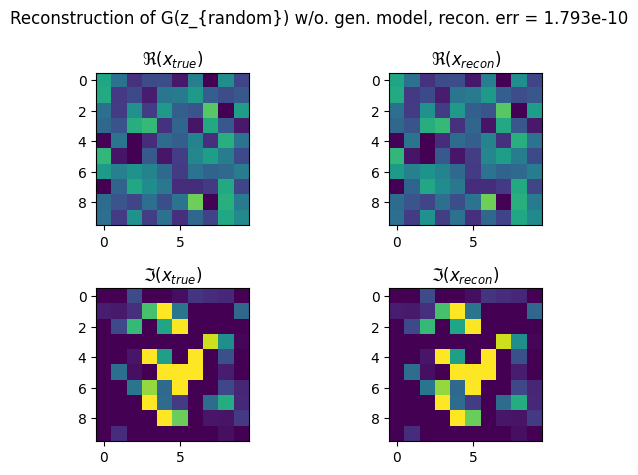

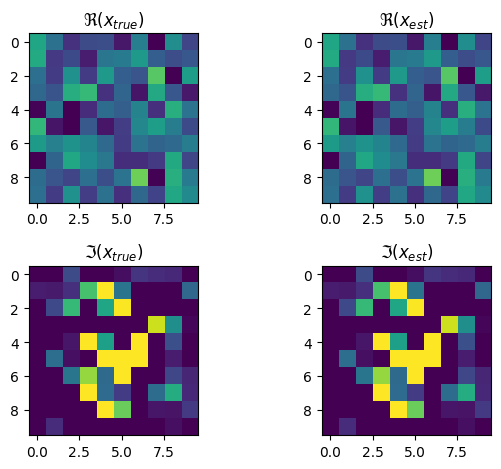

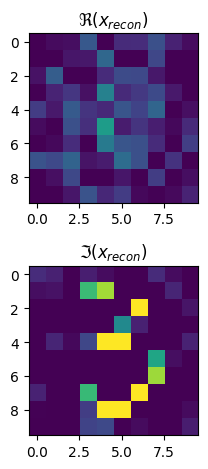

In [157]:
# test generative model itself
sigma = 0

#xtrue = datatest[np.random.randint(0,datatest.shape[0])].numpy()

x_random = np.random.normal(size=(1,sample_shape)) + 1j*np.random.normal(size=(1,sample_shape))
x_tensor = make_tensor(x_random)
x_random_recon_tf = decoder(encoder(x_tensor)) 
x_random_recon = x_random_recon_tf.numpy().flatten()

xtrue = G.eval(np.random.randn(k) + 1j*np.random.randn(k))
xtrue_1D = np.load('G(z)_ex8_goodex.npy') #x_random_recon #xtrue.flatten()

#xtrue_1D = xtrue.flatten() #x_random.flatten() # #G.eval(np.random.randn(k) + 1j*np.random.randn(k))
#xtrue_1D = np.zeros(n) + 1j*np.imag(x_random_recon)

error, xhat_corr, yobs, _ = reconstruct(xtrue_1D, A, I, Istar, w=1, sigma = sigma, lmbda = sigma)
#xhat_corr = xhat_corr.reshape((nx,nx))

print(f"Reconstruction error (sigma = {sigma}): ", error)

fig, ax = plt.subplots(2,2)

ax[0,0].imshow(np.real(xtrue_1D.reshape((nx,nx))),clim=[0,1])
ax[0,0].set_title(r'$\Re(x_{true})$')
ax[1,0].imshow(np.imag(xtrue_1D.reshape((nx,nx))),clim=[0,1])
ax[1,0].set_title(r'$\Im(x_{true})$')
ax[0,1].imshow(np.real(xhat_corr.reshape((nx,nx))),clim=[0,1])
ax[0,1].set_title(r'$\Re(x_{recon})$')
ax[1,1].imshow(np.imag(xhat_corr.reshape((nx,nx))),clim=[0,1])
ax[1,1].set_title(r'$\Im(x_{recon})$')

fig.suptitle(rf"Reconstruction of G(z_{{random}}) w/o. gen. model, recon. err = {error:.3e}")
fig.tight_layout()

plot_result(xtrue_1D, xhat_corr)

# compare with direct reconstruction of the test image
compare_y = encoder(make_tensor_shape(xtrue))
compare_x = decoder(compare_y).numpy()

fig, ax = plt.subplots(2,1)

ax[0].imshow(np.real(compare_x.reshape((nx,nx))),clim=[0,1])
ax[0].set_title(r'$\Re(x_{recon})$')
ax[1].imshow(np.imag(compare_x.reshape((nx,nx))),clim=[0,1])
ax[1].set_title(r'$\Im(x_{recon})$')

fig.tight_layout()
plt.show()

In [109]:
error_real = np.linalg.norm(np.real(xhat_corr) - np.real(xtrue_1D))/np.linalg.norm(np.real(xtrue_1D))
error_imag = np.linalg.norm(np.imag(xhat_corr) - np.imag(xtrue_1D))/np.linalg.norm(np.imag(xtrue_1D))

print(f"error real part: {error_real}")
print(f"error img part: {error_imag}")

print("norm xtrue: ", np.linalg.norm(xtrue_1D))

np.save('G(z)_ex9_randomex.npy', xtrue_1D)
np.save('G(z)_ex9_randomex_recon.npy', xhat_corr)

error real part: 3.469102310308395e-08
error img part: 4.418029281545693e-08
norm xtrue:  13.937400903513552


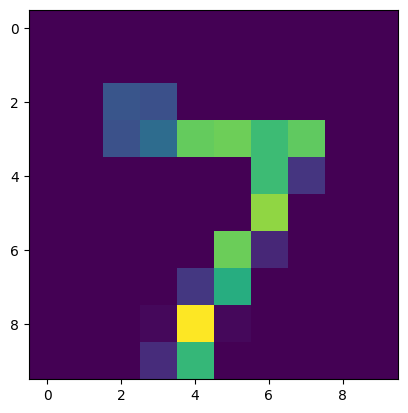

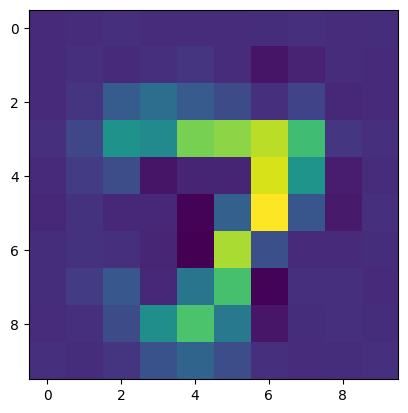

In [ ]:
# test with l2
xtrue = x_test_cx_small[0].numpy()
xtrue_1D = xtrue.flatten()

plt.figure()
plt.imshow(np.imag(xtrue))

error, xhat_corr, yobs = reconstruct(xtrue_1D, A, G, w=1, sigma=0.01, lmbda=0)

xhat_corr = xhat_corr.reshape((nx,nx))


plt.figure()
plt.imshow(np.imag(xhat_corr))

### Experiments

In [160]:
# scan over noise levels with and without generative model on in-distribution gt
ns     = 10
sigmas = np.logspace(-6,6,10)

errors_i = np.zeros((len(sigmas),ns))
xhats_i  = np.zeros((len(sigmas),ns, n),dtype='complex')

errors_g = np.zeros((len(sigmas),ns))
xhats_g  = np.zeros((len(sigmas),ns, n),dtype='complex')

errors_c = np.zeros((len(sigmas),ns))
xhats_c  = np.zeros((len(sigmas),ns, n),dtype='complex')

x_export = np.zeros((len(sigmas), ns, n), dtype='complex')
x_import = np.load('indistribution_ex.npy')

for i in range(len(sigmas)):
    print("i:", i)
    for j in range(ns):
        print("j:", j)
        xtrue = G.eval(np.random.randn(k) + 1j*np.random.randn(k)) #here xtrue comes from the generative model
        #x_export[i,j,:] = xtrue
        #xtrue = x_import[i,j,:]

        errors_i[i,j], xhats_i[i,j,:], _, _ = reconstruct(xtrue, A, I, Istar, w=1, sigma=sigmas[i], lmbda=sigmas[i])
        #errors_g[i,j], xhats_g[i,j,:], _, _ = reconstruct(xtrue, A, G, Gstar, w=1, sigma=sigmas[i], lmbda=sigmas[i])
        #errors_c[i,j], xhats_c[i,j,:], _, _ = reconstruct(xtrue, A, H, Hstar, w=1, sigma=sigmas[i], lmbda=1e1*sigmas[i])

i: 0
j: 0
val 1089135017.3388429
first element gradc (12329146.641212048+12351098.073918968j)
val 790921211.7183968
first element gradc (9715687.247336645+9736132.217372585j)
val 184730258.06648427
first element gradc (3158965.7280349666+3174208.304883166j)
val 79111145.83837773
first element gradc (1452766.5671829933+1465848.8319795218j)
val 41448158.67651323
first element gradc (566514.1623983253+578114.5827395935j)
val 32682065.97212518
first element gradc (222711.72362553398+233766.15686601234j)
val 30786871.698555574
first element gradc (80940.60834243601+92115.52176998732j)
val 30359444.412373602
first element gradc (28514.8356386139+40246.51907555516j)
val 29847672.750322927
first element gradc (-11646.187096142356+1390.689216566573j)
val 22031249.50685274
first element gradc (-125409.05613042455-123071.37222544206j)
val 1211211885.83339
first element gradc (-3921272.021290026-8106320.540486985j)
val 21835615.912706003
first element gradc (-125314.75018687404-124709.69392559328j

In [147]:
np.save('indistribution_ex.npy', x_export)

In [91]:
for i in range(len(sigmas)):
    print(f"For noise level {sigmas[i]:.8e}  |  Mean error {np.mean(errors_i[i, :]):.6e}")


For noise level 1.00000000e-06  |  Mean error 3.669532e-06
For noise level 2.15443469e-05  |  Mean error 3.746108e-06
For noise level 4.64158883e-04  |  Mean error 3.921754e-06
For noise level 1.00000000e-02  |  Mean error 2.443651e-05
For noise level 2.15443469e-01  |  Mean error 4.909864e-04
For noise level 4.64158883e+00  |  Mean error 1.059822e-02
For noise level 1.00000000e+02  |  Mean error 2.264988e-01
For noise level 2.15443469e+03  |  Mean error 3.837532e-01
For noise level 4.64158883e+04  |  Mean error 1.000000e+00
For noise level 1.00000000e+06  |  Mean error 1.000000e+00


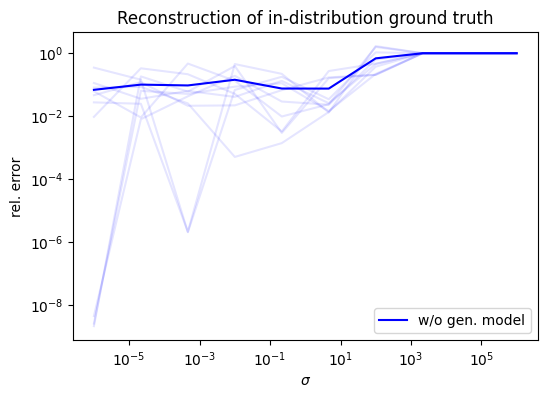

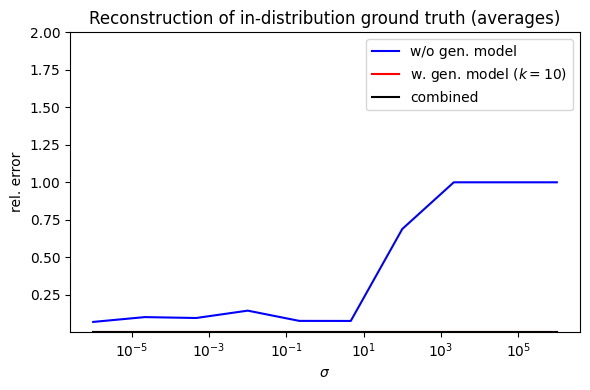

In [161]:
fig, ax = plt.subplots(1, figsize = (6,4))

ax.loglog(sigmas, np.mean(errors_i,axis=1), 'b', label='w/o gen. model')
ax.loglog(sigmas, errors_i, 'b', alpha=1/ns)

# ax.loglog(sigmas, np.mean(errors_g,axis=1), 'r', label='w. gen. model ($k=$%d)'%k)
# ax.loglog(sigmas, errors_g, 'r', alpha=1/ns)

# ax.loglog(sigmas, np.mean(errors_c,axis=1), 'k', label='combined')
# ax.loglog(sigmas, errors_c, 'k', alpha=1/ns)

# for scatter plot version

# for i in range(errors_i.shape[1]):
#     ax.scatter(sigmas, errors_i[:, i], color='b', alpha=1/ns, s=10)

# for i in range(errors_g.shape[1]):
#     ax.scatter(sigmas, errors_g[:, i], color='r', alpha=1/ns, s=10)

# for i in range(errors_c.shape[1]):
#     ax.scatter(sigmas, errors_c[:, i], color='k', alpha=1/ns, s=10)

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel('rel. error')
ax.set_title('Reconstruction of in-distribution ground truth')
ax.legend()
#plt.savefig('MNIST_100_decoder_indistribution_lines.png', dpi=300)
plt.show()


# only averages
fig, ax = plt.subplots(1, figsize = (6,4))

ax.plot(sigmas, np.mean(errors_i, axis=1), 'b', label='w/o gen. model')
ax.plot(sigmas, np.mean(errors_g, axis=1), 'r', label='w. gen. model ($k=$%d)' % k)
ax.plot(sigmas, np.mean(errors_c, axis=1), 'k', label='combined')

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel('rel. error')
ax.set_title('Reconstruction of in-distribution ground truth (averages)')

ax.set_xscale('log') 
ax.set_ylim([0.001, 2])

# Optional: tighten x range to only include data
#ax.set_xlim([min(sigmas), max(sigmas)])

ax.legend()
plt.tight_layout()
#plt.savefig('MNIST_100_decoder_indistribution_averages.png', dpi=300)
plt.show()



In [97]:
# scan over noise levels with and without generative model on out-of-distribution gt
ns     = 10
sigmas = np.logspace(-6,6,10)

errors_i = np.zeros((len(sigmas),ns))
xhats_i  = np.zeros((len(sigmas),ns, n),dtype='complex')

errors_g = np.zeros((len(sigmas),ns))
xhats_g  = np.zeros((len(sigmas),ns, n),dtype='complex')

errors_c = np.zeros((len(sigmas),ns))
xhats_c  = np.zeros((len(sigmas),ns, n),dtype='complex')

for i in range(len(sigmas)):
    print("i:", i)
    for j in range(ns):
        print("j:", j)
        xdatatest = datatest[np.random.randint(0,datatest.shape[0])].numpy()
        xtrue = xdatatest.flatten()
        
        errors_i[i,j], xhats_i[i,j,:], _, _ = reconstruct(xtrue, A, I, Istar, w=1, sigma=sigmas[i], lmbda=sigmas[i])
        errors_g[i,j], xhats_g[i,j,:], _, _ = reconstruct(xtrue, A, G, Gstar, w=1, sigma=sigmas[i], lmbda=sigmas[i])
        errors_c[i,j], xhats_c[i,j,:], _, _ = reconstruct(xtrue, A, H, Hstar, w=1, sigma=sigmas[i], lmbda=1e1*sigmas[i])

i: 0
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 1
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 2
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 3
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 4
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 5
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 6
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 7
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 8
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 9
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9


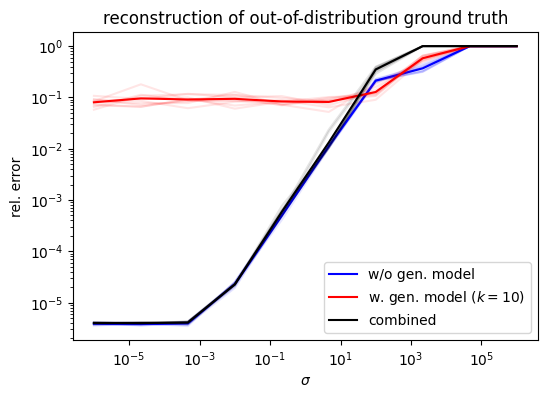

In [99]:
fig, ax = plt.subplots(1, figsize = (6,4))

ax.loglog(sigmas, np.mean(errors_i,axis=1), 'b', label='w/o gen. model')
ax.loglog(sigmas, errors_i, 'b', alpha=1/ns)

ax.loglog(sigmas, np.mean(errors_g,axis=1), 'r', label='w. gen. model ($k=$%d)'%k)
ax.loglog(sigmas, errors_g, 'r', alpha=1/ns)

ax.loglog(sigmas, np.mean(errors_c,axis=1), 'k', label='combined')
ax.loglog(sigmas, errors_c, 'k', alpha=1/ns)

# for scatter plot version

# for i in range(errors_i.shape[1]):
#     ax.scatter(sigmas, errors_i[:, i], color='b', alpha=1/ns, s=10)

# for i in range(errors_g.shape[1]):
#     ax.scatter(sigmas, errors_g[:, i], color='r', alpha=1/ns, s=10)

# for i in range(errors_c.shape[1]):
#     ax.scatter(sigmas, errors_c[:, i], color='k', alpha=1/ns, s=10)

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel('rel. error')
ax.set_title('reconstruction of out-of-distribution ground truth')

ax.legend()
#plt.savefig('MNIST_100_decoder_outdistribution.png', dpi=300)

In [25]:
## bias experiments
# different samples for computing bias as the z0-term for in and out-distribution
ns     = 10

errors_in = np.zeros(ns)
xhats_in  = np.zeros((ns, n),dtype='complex')

errors_out = np.zeros(ns)
xhats_out  = np.zeros((ns, n),dtype='complex')


for j in range(ns):
    x_in = G.eval(np.random.randn(k) + 1j*np.random.randn(k))
    x_out = datatest[np.random.randint(0,datatest.shape[0])].numpy().flatten()

    errors_in[j], xhats_in[j,:], _, _ = reconstruct(x_in, I, G, Gstar, w=1, sigma=0, lmbda=0)
    errors_out[j], xhats_out[j,:], _, _ = reconstruct(x_out, I, G, Gstar, w=1, sigma=0, lmbda=0)

print(f"%Mean bias in-distr {np.mean(errors_in):.6e}  |  Std dev {np.std(errors_in):.6e}")
print(f"%Mean bias out-distr {np.mean(errors_out):.6e}  |  Std dev {np.std(errors_out):.6e}")

%Mean bias in-distr 1.167888e+00  |  Std dev 1.355289e-01
%Mean bias out-distr 7.596232e-01  |  Std dev 5.185993e-02


In [27]:
# different samples for computing bias as the zhat-term for in and out-distribution of the H-term
ns     = 10

errors_in = np.zeros(ns)
bias_in = np.zeros(ns)
xhats_in  = np.zeros((ns, n),dtype='complex')

errors_out = np.zeros(ns)
bias_out = np.zeros(ns)
xhats_out  = np.zeros((ns, n),dtype='complex')


for j in range(ns):
    x_in = G.eval(np.random.randn(k) + 1j*np.random.randn(k))
    x_out = datatest[np.random.randint(0,datatest.shape[0])].numpy().flatten()

    errors_in[j], xhats_in[j,:], _, result_in = reconstruct(x_in, I, H, Hstar, w=1, sigma=0, lmbda=1)
    errors_out[j], xhats_out[j,:], _, result_out = reconstruct(x_out, I, H, Hstar, w=1, sigma=0, lmbda=1)

    x1x2_in = result_in.x[:k+n] + 1j*result_in.x[k+n:]
    x2_in = x1x2_in[k:]
    G_z_temp = xhats_in[j,:] - x2_in
    phi = np.mean(np.angle(x_in/G_z_temp)) # angle correction now has to happen outside of the reconstruct function
    G_z_in = np.exp(1j*phi)*G_z_temp
    bias_in[j] = np.linalg.norm(G_z_in - x_in)/np.linalg.norm(x_in)

    x1x2_out = result_out.x[:k+n] + 1j*result_out.x[k+n:]
    x2_out = x1x2_out[k:]
    G_z_temp = xhats_out[j,:] - x2_out
    phi = np.mean(np.angle(x_out/G_z_temp)) 
    G_z_out = np.exp(1j*phi)*G_z_temp
    bias_out[j] = np.linalg.norm(G_z_out - x_out)/np.linalg.norm(x_out)

print(f"%Mean bias in-distr {np.mean(bias_in):.6e}  |  Std dev {np.std(bias_in):.6e}")
print(f"%Mean bias out-distr {np.mean(bias_out):.6e}  |  Std dev {np.std(bias_out):.6e}")

%Mean bias out-distr 9.298423e-01  |  Std dev 5.190562e-02
%Mean bias out-distr 5.438300e-01  |  Std dev 2.704658e-02
